<a href="https://colab.research.google.com/github/patrick-hanley/thought_experiments/blob/master/_notebooks/2021_02_21_feature_engineering_numerical_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Useful tools for transforming the input features"
> "Incredibly usefull tool to analyze and preprocess data for a deep neural network"


- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

#    ![img]{{ site.baseurl }}/images/wine_dataset/skew_alcohol.png)

In [ ]:
#hide
# Standard Library Imports

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai --upgrade --q
from pathlib import Path
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
import numpy as np
from scipy.stats import kurtosis, skew
from scipy import stats
import math
import warnings
warnings.filterwarnings("error")

from google.colab import drive
mnt=drive.mount('/content/gdrive', force_remount=True)



     |████████████████████████████████| 194kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
Mounted at /content/gdrive


# I will explore the transformations using the [wine data set](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) from Kaggle.

In [ ]:
#hide
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'redwine'
csv_path = (base_dir+'/winequality-red.csv')
df=pd.read_csv(csv_path)

# The following numerical transformations will be evaluated on the dataset:


*   Log 
*   Square Root
*   Box-Cox
*   Yeo-Yohnson
*   Quantile
*   Clipping



In [ ]:
#hide

# https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/
def box_cox_transform(bc, X_train, X_test):
  
  try:
    X_trans_bc = bc.fit(X_train).transform(X_test)
  except:
    # datax = max(X_train+1) - X_train
    # datay = max(X_train+1) - X_train
    datax, datay = reverse_distribution(X_train, X_test)
    X_trans_bc = bc.fit(datax).transform(datay)
  return X_trans_bc

def log_transform(x):
  try:
    X_trans = np.log(x)
  except:
    datax, datay = reverse_distribution(x, x)
    X_trans = np.log(datax)
  return X_trans

def sqrt_transform(x):
  return np.sqrt(x)

def reverse_distribution(X_train, X_test):
  # data can not have negative values
  datax = max(X_train+1) - X_train
  datay = max(X_test+1) - X_test
  return (datax, datay)

def get_stats(trns_name, data):
  s = skew(data)
  s_str = '%.2f'%(s)
  k = '%.2f'%(kurtosis(data))
  k2, p = stats.normaltest(data)
  ks = '%.2f'%(k2)
  # pvalue = '%.2f'%(p)
  title = "\n".join([trns_name, s_str, k, ks])
  return (s, k2, title)

def plot_transforms(df, feat, log=False):
  #rng = np.random.RandomState(304)
  N_SAMPLES = 1000
  FONT_SIZE = 10
  BINS = 100
  # initialize models
  bc = PowerTransformer(method='box-cox')
  yj = PowerTransformer(method='yeo-johnson')
  # n_quantiles is set to the training set size rather than the default value
  # to avoid a warning being raised by this example
  qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                          random_state=0)
  X=df.iloc[:,feat]
  print (df.columns[feat], X.nunique())
  

  if len(X.unique())> 10:
    X = X.values.reshape(-1, 1)


    # perform power transforms and quantile transform
    X_trans_bc = box_cox_transform(bc, X, X) # bc.fit(X_train).transform(X_test)

    X_trans_yj = yj.fit(X).transform(X)

    X_trans_qt = qt.fit(X).transform(X)

    X_trans_sqrt = sqrt_transform(X)

    X_trans_log = log_transform(X)

    transforms = [X, X_trans_bc, X_trans_yj, X_trans_qt, X_trans_sqrt,
                  X_trans_log]
    titles = ['train', 'trans_bc', 'trans_yj', 'trans_qt', 
              'trans_sqrt', 'trans_log']

  else:
    X = X.values.reshape(-1, 1)
    transforms = [X]
    titles = ['X_train']


  #Set up fix and axes for plotting
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=plt.figaspect(.2), 
                           sharey=True)

  # trackers for skew and kurtosis
  s_best = 9999.
  k_best= 9999.
  title_best=[]
  best_model=''
  for t, ax, trns_name in zip(transforms, axes, titles):
    
    # histogram each model
    ax.hist(t, bins=BINS, log=log, range=(np.nanmin(t), np.nanmax(t)))
    
    # analyze distribution
    s, k2, title = get_stats(trns_name, t)


    # find best skew, then best kurtosis
    if abs(s) < s_best:
      title_best = title
      t_best = t
      s_best = abs(s)
      best_model = trns_name
    elif abs(s)==s_best:
      if abs(k2) < k_best:
        title_best = title
        k_best = abs(k2)
        t_best=t
        best_model = trns_name
    
    title = "\n".join([df.columns[feat], title])
    ax.set_title(title, fontsize=FONT_SIZE)

  col = '_'.join([df.columns[feat], best_model]) 
  
  transfored_df = pd.DataFrame(t_best, columns=[col])

  print ("Best:{}".format(best_model))
  plt.show()

  # return transformed array from the best model
  return (transfored_df)

def remove_outliers(X):
  mean = np.mean(X)
  standard_deviation = np.std(X)
  distance_from_mean = abs(X - mean)
  max_deviations = 1.5
  not_outlier = distance_from_mean < max_deviations * standard_deviation
  no_outliers = X[not_outlier]
  return no_outliers



def clip_feature(df, max_deviations=2, type='std'):
  """provide dataFrame and get a clipped daataframe back including 2 additional
  columns indicating the index of clippage.
  """

  clipped_dfs = []
  for feature in df.columns:

    mean = df[feature].mean()
    standard_deviation = df[feature].std()

    upper = mean + (max_deviations * standard_deviation)
    lower = mean - (max_deviations * standard_deviation)
    val = df[feature].values

    if type == 'std':
      lower_value = lower
      upper_value = upper
      V = np.clip(val, lower_value, upper_value, out=None)
    elif type == 'mean':
      lower_value = mean
      upper_value = mean
      V = np.where((val<lower)|(val>upper), mean, val)
      
    elif type == 'median':
      median = df[feature].median()
      lower_value = median
      upper_value = median
      V = np.where((val<lower)|(val>upper), median, val)

    #V = np.clip(val, lower_value, upper_value, out=None)
    clip_low = np.where(val<lower, True, False)
    clip_high = np.where(val>upper, True, False)

    #confirm the series was clipped
    len_low = len(np.unique(clip_low, return_counts=True)[1])
    len_high = len(np.unique(clip_high, return_counts=True)[1])

    if (len_low)>1 or (len_high)>1:
      clipped_name = '_'.join(['clip', type, str(max_deviations), feature])
      is_clipped_low = '_'.join(['IS_CLIP_LOW', type, str(max_deviations), feature])
      is_clipped_high = '_'.join(['IS_CLIP_HIGH', type, str(max_deviations), feature])
      dv=pd.DataFrame({clipped_name:V, is_clipped_low:clip_low, is_clipped_high:clip_high} )
    
      clipped_dfs.append(dv)
  clipped_dfs = pd.concat(clipped_dfs, axis=1)
  return clipped_dfs



# I came across this funtion on Kaggle(I think) and found it incredibly helpful
# https://gist.github.com/harperfu6/5ea565ee23aaf8461a840c480490cd9a
from scipy import stats
pd.set_option("display.max_rows", 1000)
def resumetable(df):
    print(f'Dataset Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    
    return summary

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

# Lets take a quick look at our data.

*   11 features and 1 target
*   1600 rows of data

For a more in depth analysis see the previous blog XXXX.



In [ ]:
#hide
resumetable(df)

Dataset Shape: (1599, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,fixed acidity,float64,0,96,7.4000,7.8000,7.800,5.94
1,volatile acidity,float64,0,143,0.7000,0.8800,0.760,6.39
2,citric acid,float64,0,80,0.0000,0.0000,0.040,5.87
3,residual sugar,float64,0,91,1.9000,2.6000,2.300,4.78
4,chlorides,float64,0,153,0.0760,0.0980,0.092,6.22
5,free sulfur dioxide,float64,0,60,11.0000,25.0000,15.000,5.08
6,total sulfur dioxide,float64,0,144,34.0000,67.0000,54.000,6.60
7,density,float64,0,436,0.9978,0.9968,0.997,7.96
8,pH,float64,0,89,3.5100,3.2000,3.260,5.91
9,sulphates,float64,0,96,0.5600,0.6800,0.650,5.73


I wanted a simple way to visualize the distributions of the feaatures and also quickly see how they could be transormed into a guasian distribution needed for neural networks.  I created a library that runs the Transforms listed above on each feature and automatically selects the optimal transform based on the skew and kurtosis.

Let's see an example.  The plots below are only evaluating 1 feature ('alcohol'), however, in practice, we would do this for the entire dataset.

alcohol 65
Best:trans_qt


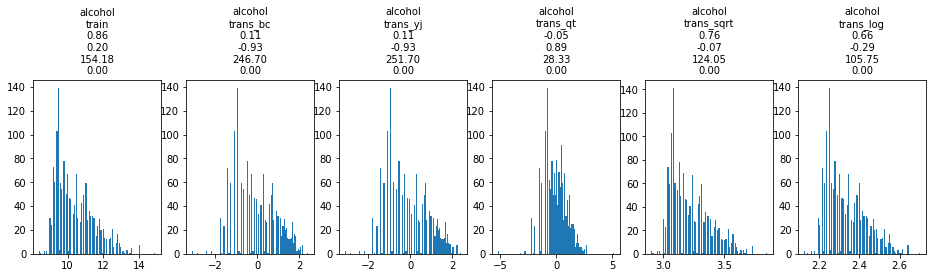

In [ ]:
#hide
trans_alcohol_df = plot_transforms(df, df.columns.get_loc('alcohol'), log=False)

!['did this work2?']({{ site.url }}{{ site.baseurl }}/images/wine_dataset/skew_alcohol.png)

In the plot above, we visually see that the most gausian distribution came from the Quantile Transformation.  This is also the Transformation that was automatically selected based on skew and kertosis as the most optimum.

Same data as above, but on a log scale

alcohol 65
Best:trans_qt


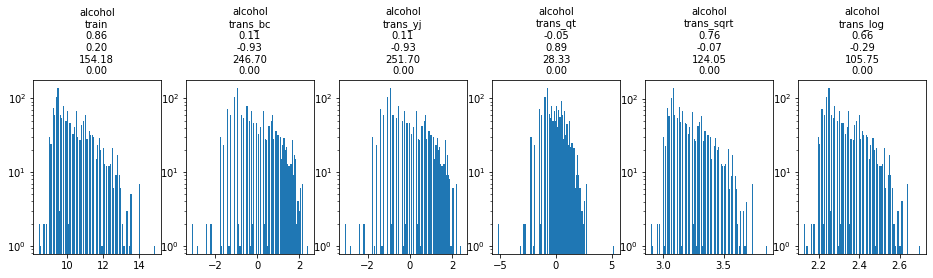

In [ ]:
#hide
_ = plot_transforms(df, df.columns.get_loc('alcohol'), log=True)

Lets now clip the data to a limit of 2 standard deviations and then run it through the transforms.

The Clip transformation does a few things.


1.   Clips values to be within X number of standard deviations.
2.   The values outside the range, will be adjusted to 1 of the 3 options:
>*  X standard deviations
>*  mean
>*  median
3.   Additional columns will be added to indicate if a value was clipped low or high.




Let's see a sample output.
